# Hypercube Integrator

Given a collection of hypercubes (in this case rectangles) that fully occupy (without overlaps) a larger hypercube (rectangle), what's the integral if we sum over the points in the rectangles from one side of the space to the other:

        -----------> +
    4   ______________
    3  |    | 4  |    |     [2+8+4]   [14]
    2  | 1  |____| 2  |     [2+8+4]   [14]
    1  |    | 3  |    |  =  [2+6+4] = [12]
    0  |____|____|____|     [2+6+4]   [12]
       0 1  2 3  4 5  6
       
We represent these rectangles with the start-end along each dimension. For example the rectangle on the right would be `np.array([4,6],[0,4])`. We put all these rectangles together in another array (making an `N x D x 2` numpy array), in this case a `4 x 2 x 2` array.

We also specify the 'gradient' within each hypercuboid (rectangle) in a second list, each element corresponding to one of the rectangles in the first.

We then call sumovercuboids and specify the dimension we want to integrate over:

In [1]:
import numpy as np
from hypercuboid_integrator import sumovercuboids

B = np.array([np.array([[0,2],[0,6]]),np.array([[4,6],[0,6]]),np.array([[2,4],[0,3]]),np.array([[2,4],[3,6]])])
grads = np.array([[1],[2],[3],[4]])

seglist = sumovercuboids(B,grads,0)
seglist

[{'grad': 0, 'int': 12, 'patch': [array([0]), array([3])]},
 {'grad': 0, 'int': 14, 'patch': [array([3]), array([6])]}]

The `seglist` is a list of hypercubes (of D-1 dimensions). We can see that the integrals in the figure above can be split into two parts: from 0 to 2 and from 2 to 4. The grad value can be ignored. the int value gives the integral in that patch, and patch describes the start and end coordinates of the integrated area.

To demonstrate a higher dimensional example, here we have two `2x5x2x2` hypercuboids, one at (0,0,0,0) and one at (0,0,2,0). We integrate over the longer axis (1), thus we have two cubes output when we've marginalised over that dimension. One at (0,0,0) and one at (0,2,0). The first hyper cuboid has a 'gradient' of 4, the second, 2. Thus integrating over a domain of 5, the results are 20 and 10, respectively:

In [2]:
B = np.array([np.array([[0,2],[0,5],[0,2],[0,2]]),np.array([[0,2],[0,5],[2,4],[0,2]])])
grads = np.array([[4],[2]])
seglist = sumovercuboids(B,grads,1)
seglist

[{'grad': 0, 'int': 20, 'patch': [array([0, 0, 0]), array([2, 2, 2])]},
 {'grad': 0, 'int': 10, 'patch': [array([0, 2, 0]), array([2, 4, 2])]}]

## Testing symmetry

In [8]:
B0 = np.array([np.array([[ 0. ,  0.5],[ 0.5,  1. ]]),
     np.array([[ 0.5,  1. ],[ 0.5,  1. ]]), 
     np.array([[ 0. ,  0.5],[ 0. ,  0.5]]), 
     np.array([[ 0.5,  1. ],[ 0. ,  0.5]])])
grads0 = np.array([[0.77,0.91,0.62,0.85]]).T
B1 = np.array([np.array([[ 0.5,  1. ],[ 0. ,  0.5]]),
     np.array([[ 0.5,  1. ],[ 0.5,  1. ]]), 
     np.array([[ 0. ,  0.5],[ 0. ,  0.5]]),
     np.array([[ 0. ,  0.5],[ 0.5,  1. ]])])
grads1 = np.array([[ 0.77,0.91,0.62,0.85]]).T

sumovercuboids(B0,grads0,0)

[{'grad': 0.0,
  'int': 0.73499999999999999,
  'patch': [array([ 0.]), array([ 0.5])]},
 {'grad': 0.0,
  'int': 0.84000000000000008,
  'patch': [array([ 0.5]), array([ 1.])]}]

In [9]:
sumovercuboids(B1,grads1,1)

[{'grad': 0.0,
  'int': 0.73499999999999999,
  'patch': [array([ 0.]), array([ 0.5])]},
 {'grad': 0.0,
  'int': 0.84000000000000008,
  'patch': [array([ 0.5]), array([ 1.])]}]

# 3d example

In [17]:
import numpy as np
from hypercuboid_integrator import sumovercuboids

B = np.array([np.array([[0,2],[0,6],[0,1]]),np.array([[4,6],[0,6],[0,1]]),np.array([[2,4],[0,3],[0,1]]),np.array([[2,4],[3,6],[0,1]])])
grads = np.array([[1],[2],[3],[4]])

seglist = sumovercuboids(B,grads,0)
seglist

[{'grad': 0, 'int': 12, 'patch': [array([0, 0]), array([3, 1])]},
 {'grad': 0, 'int': 14, 'patch': [array([3, 0]), array([6, 1])]}]

# n-d example

In [27]:
B

array([[[ 0, 10],
        [ 0, 10],
        [ 0, 10]]])

In [99]:
import numba as nb
import numpy as np

#@nb.jit(nb.typeof(([[1.0,1.0],[1.0,1.0]],[True,False]))(nb.double,nb.double,nb.double,nb.double))
@nb.jit(nopython=True)
def split1d(Astart,Aend,Bstart,Bend):
    """For a 1-d pair of lines A and B:
    given start and end locations,
    produce new set of points for A, split by B.
    
    For example:
    split1d(1,9,3,5)
    splits the line from 1 to 9 into 3 pieces,
    1 to 3
    3 to 5
    and
    5 to 9
    it returns these three pairs and a list of whether
    those points were inside B.
    In this case the list is [False,True,False]
    """
    #five options
    #1 A and B don't intersect. This shouldn't happen
    if (Astart>=Bend) or (Bstart>=Aend):
        #Not sure what to do
        assert False
    #2 B starts first, and ends inside A:
    if (Astart>=Bstart) and (Bend<Aend):
        #return Astart-Bend Bend-Aend
        return [(Astart,Bend),(Bend,Aend)], [True, False]
    #3 B extends beyond limits of A in both directions:
    if (Bstart<=Astart) and (Bend>=Aend):
        #return A
        return [(Astart,Aend)], [True]
    #4 B starts in A and finishes after A
    if (Astart<Bstart) and (Bend>=Aend):
        #return Astart-Bstart Bstart-Aend
        return [(Astart,Bstart),(Bstart,Aend)], [False,True]
    #5 B is inside A
    if (Astart<Bstart) and (Bend<Aend):
        #return Astart-Bstart Bstart-Bend Bend-Aend
        return [(Astart,Bstart),(Bstart,Bend),(Bend,Aend)], [False,True,False]
    
#@nb.jit(nopython=True)
#@nb.jit(nb.typeof(([((1.0,1.0),(1.0,1.0))]))((nb.double,nb.double),(nb.double,nb.double),(nb.double,nb.double),(nb.double,nb.double),nb.int32),nopython=True)
def splitslice(Astart,Aend,Bstart,Bend,d):
    """given start and end locations, produce new set of points for A split by B
    just in dimension d.""" 
    
    chunks, inside = split1d(Astart[d],Aend[d],Bstart[d],Bend[d])
    
    res = np.empty([len(chunks),2])
    
    for i,chunk in enumerate(chunks):
        newstart = Astart
        newend = Aend
        newstart[d] = chunk[0]
        newend[d] = chunk[1] 
        res[i,:] = np.array([newstart,newend])
        """
    return res , inside
    """
    
#@nb.jit(nopython=True)
#def test(a,b,c,d):
#    for it in range(1000):
#        x = split1d(a,b,c,d)
#    return x
#%timeit 
splitslice(np.array([0.0,1.0]),np.array([2.0,3.0]),np.array([1.0,1.0]),np.array([3.0,2.0]),0)
#%timeit test(1.0,3.0,2.0,4.0) #341us without, 304us with.

ValueError: could not broadcast input array from shape (2,2) into shape (2)

In [88]:
@nb.jit(nopython=True)
def test():
    tuple([1,2])
test()


TypingError: Failed at nopython (nopython frontend)
Untyped global name 'tuple': cannot determine Numba type of <class 'type'>
File "<ipython-input-88-ca8693957c43>", line 3

In [80]:
nb.jit(nb.typeof((1.0,1.0))(nb.double[:]))(tuple)([1,2])

ValueError: no signature found for builtin type <class 'tuple'>

In [61]:
splitslice.inspect_types()

In [43]:
a = [1,2]
*a,

(1, 2)

In [22]:
import numpy as np
from hypercuboid_integrator import sumovercuboids


for i in range(100):
    p = np.random.rand()
    
grads = np.array([[1],[2],[3],[4]])

seglist = sumovercuboids(B,grads,0)
seglist

[{'grad': 2, 'int': 10, 'patch': [array([0, 0]), array([10, 10])]}]

In [1]:
import numpy as np
from hypercuboid_integrator import sumovercuboids
B = [np.array([[0,10],[0,5],[0,10],[0,20]])*1.0]
np.random.seed(1)
for it in range(70):
    i = np.random.randint(len(B))
    d = np.random.randint(B[0].shape[0])
    p = (np.random.rand()*(B[i][d][1]-B[i][d][0]))+B[i][d][0]
    newB1 = B[i].copy()
    newB2 = B[i].copy()
    newB1[d][1] = p
    newB2[d][0] = p
    B.pop(i)
    B.append(newB1)
    B.append(newB2)
grads = np.random.rand(len(B),1)


%timeit sumovercuboids(np.array(B),grads,0)

[  5.  10.  20.]
[ 0.          0.          2.56248896]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.          0.          2.56248896]
[ True  True  True]
[  5.  10.  20.]
[ 0.          0.          2.56248896]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.          0.          2.56248896]
[ True  True  True]
[  5.  10.  20.]
[ 0.          0.          2.56248896]
[ True  True  True]
[  4.98592405  10.           2.56248896]
[ 0.         0.         0.6049754]
[ True  True  True]
[  4.98592405  10.           2.56248896]
[ 0.         0.         0.6049754]
[ True  True  True]
[  4.98592405  10.           2.56248896]
[ 0.         0.         0.6049754]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.         0.         0.6049754]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.         0.         0.6049754]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.         0.         0.6049754]
[ True  True  True]
[

[ 0.          0.          0.56814921]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.          0.          0.56814921]
[ True  True  True]
[  4.98592405  10.          20.        ]
[ 0.          0.          0.56814921]
[ True  True  True]
[  5.  10.  20.]
[ 0.          0.          0.56814921]
[ True  True  True]
[  5.  10.  20.]
[ 0.          0.          0.56814921]
[ True  True  True]
[  5.  10.  20.]
[ 0.          0.          0.56814921]
[ True  True  True]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 4.99736773  0.          0.        ]
[False  True  True]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 4.99736773  0.          0.        ]
[False  True  True]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 4.99736773  0.          0.        ]
[False  True  True]
[  2.05314309  10.           0.56814921]
[ 4.99736773  0.          0.        ]
[False  True  True]
[  2.05314309  10.           0.56814921]
[ 4.99736773  0.          0.        ]
[False  

[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.56814921]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.56814921]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.56814921]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.6049754 ]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.6049754 ]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  3.86309395  10.           0.6049754 ]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  4.98592405e+00   1.00000000e+01   2.55011295e-03]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  4.98592405e+00   1.00000000e+01   2.55011295e-03]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[  4.98592405e+00   1.00000000e+01   2.55011295e-03]
[ 0.          9.35539071  2.56248896]
[ True  True False]
[ 4.98592405  7

[ 3.46222645  9.35539071  9.74956195]
[False False False]
[ 2.48377218  9.35539071  3.93598051]
[ 3.46222645  9.35539071  9.74956195]
[False False False]
[ 2.48377218  9.35539071  3.93598051]
[ 3.46222645  9.35539071  9.74956195]
[False False False]
[  2.48377218   9.35539071  10.53500285]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.35539071  10.53500285]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.35539071  10.53500285]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.35539071  20.        ]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.35539071  20.        ]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.35539071  20.        ]
[ 3.46222645  9.35539071  9.74956195]
[False False  True]
[  2.48377218   9.52240099  10.29520369]
[ 3.46222645  9.35539071  9.74956195]
[False  True  True]
[  2.48377218   9.52240099  10.29520369]
[ 3.46222645  9.

[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.01100332]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.01100332]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.56814921]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.56814921]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.56814921]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.6049754 ]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.6049754 ]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           0.6049754 ]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.           2.56248896]
[  0.53531525   6.37285777  10.53500285]
[ True  True False]
[  4.98592405  10.   

[ True  True  True]
[  2.48377218   7.04099227  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   7.04099227  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   9.35539071  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   9.35539071  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   9.35539071  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   9.52240099  10.29520369]
[  0.           6.74100165  10.53500285]
[ True  True False]
[  2.48377218   9.52240099  10.29520369]
[  0.           6.74100165  10.53500285]
[ True  True False]
[  2.48377218   9.52240099  10.29520369]
[  0.           6.74100165  10.53500285]
[ True  True False]
[  2.48377218   9.52240099  20.        ]
[  0.           6.74100165  10.53500285]
[ True  True  True]
[  2.48377218   9.52240099  20.        ]
[  0.           6.741

[ True  True  True]
[  4.98592405   9.35539071  20.        ]
[  0.           2.93079615  10.53500285]
[ True  True  True]
[  4.98592405   9.35539071  20.        ]
[  0.           2.93079615  10.53500285]
[ True  True  True]
[  4.98592405   9.35539071  20.        ]
[  0.           2.93079615  10.53500285]
[ True  True  True]
[ 4.98592405  9.67226333  9.74956195]
[  0.           2.93079615  10.53500285]
[ True  True False]
[ 4.98592405  9.67226333  9.74956195]
[  0.           2.93079615  10.53500285]
[ True  True False]
[ 4.98592405  9.67226333  9.74956195]
[  0.           2.93079615  10.53500285]
[ True  True False]
[  4.98592405   9.67226333  10.29520369]
[  0.           2.93079615  10.53500285]
[ True  True False]
[  4.98592405   9.67226333  10.29520369]
[  0.           2.93079615  10.53500285]
[ True  True False]
[  4.98592405   9.67226333  10.29520369]
[  0.           2.93079615  10.53500285]
[ True  True False]
[  4.98592405   9.67226333  20.        ]
[  0.           2.93079615  10

[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.          5.61580472  2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  20.        ]
[ 0.          5.61580472  2.56248896]
[ True  Tr

[ 0.80730351  0.          2.56248896]
[ True  True  True]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309e+00   1.00000000e+01   2.55011295e-03]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.01100332]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.01100332]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.01100332]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.56814921]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.56814921]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  10.           0.56814921]
[ 0.09105107  1.06066815  2.56248896]
[ True  True False]
[  2.05314309  

[  0.53531525   6.74100165  11.41336224]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  11.41336224]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  11.41336224]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  11.41336224]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  20.        ]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  20.        ]
[  0.           9.35539071  10.29520369]
[ True False  True]
[  0.53531525   6.76846772  20.        ]
[  0.           9.35539071  10.29520369]


[ True  True  True]
[  4.98592405   2.93079615  20.        ]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   2.93079615  20.        ]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[ 4.98592405  5.61580472  3.93598051]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[ 4.98592405  5.61580472  3.93598051]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[ 4.98592405  5.61580472  3.93598051]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   5.61580472  10.53500285]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   5.61580472  10.53500285]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   5.61580472  10.53500285]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   5.61580472  11.41336224]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]
[  4.98592405   5.61580472  11.41336224]
[ 2.66454716  0.84341085  2.56248896]
[ True  True  True]

[ 4.98592405  7.89279328  0.56814921]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  7.89279328  0.56814921]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  7.89279328  0.56814921]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  7.89279328  0.6049754 ]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  7.89279328  0.6049754 ]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  7.89279328  0.6049754 ]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  8.33873747  0.01100332]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  8.33873747  0.01100332]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  8.33873747  0.01100332]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  8.33873747  0.56814921]
[ 4.10224318  2.6629082   2.56248896]
[ True  True False]
[ 4.98592405  8.33873747  0.56814921]
[ 

[  3.98206599   5.61580472  10.53500285]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  10.53500285]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  11.41336224]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  11.41336224]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  11.41336224]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  20.        ]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  20.        ]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[  3.98206599   5.61580472  20.        ]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[ 3.98206599  9.35539071  3.93598051]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[ 3.98206599  9.35539071  3.93598051]
[ 2.66454716  0.          2.56248896]
[ True  True  True]
[ 3.98206599  9.

[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   5.61580472  20.        ]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   5.61580472  20.        ]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   5.61580472  20.        ]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[ 4.10224318  9.35539071  3.93598051]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[ 4.10224318  9.35539071  3.93598051]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[ 4.10224318  9.35539071  3.93598051]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   9.35539071  10.53500285]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   9.35539071  10.53500285]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   9.35539071  10.53500285]
[ 4.32658457  0.          2.56248896]
[False  True  True]
[  4.10224318   6.37285777  11.41336224]
[ 4.32658457  0.   

[False  True False]
[  2.05314309  10.           0.01100332]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.56814921]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.56814921]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.56814921]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.57327822]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.57327822]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.57327822]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.6049754 ]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.6049754 ]
[ 4.10224318  0.          2.56248896]
[False  True False]
[  2.05314309  10.           0.6049754 ]
[ 4.10224318  0.          2.56248896]
[False  Tr

[ True False  True]
[  3.98206599   6.37285777  11.41336224]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.37285777  20.        ]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.37285777  20.        ]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.37285777  20.        ]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  11.41336224]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  11.41336224]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  11.41336224]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  20.        ]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  20.        ]
[  0.           9.35539071  10.87014689]
[ True False  True]
[  3.98206599   6.74100165  20.        ]
[  0.           9.355

[ True  True  True]
[  3.46222645  10.          20.        ]
[  0.           9.96428526  10.87014689]
[ True  True  True]
[  3.46222645  10.          20.        ]
[  0.           9.96428526  10.87014689]
[ True  True  True]
[ 3.98206599  9.67226333  9.74956195]
[  0.           9.96428526  10.87014689]
[ True False False]
[ 3.98206599  9.67226333  9.74956195]
[  0.           9.96428526  10.87014689]
[ True False False]
[ 3.98206599  9.67226333  9.74956195]
[  0.           9.96428526  10.87014689]
[ True False False]
[  3.98206599   9.67226333  10.29520369]
[  0.           9.96428526  10.87014689]
[ True False False]
[  3.98206599   9.67226333  10.29520369]
[  0.           9.96428526  10.87014689]
[ True False False]
[  3.98206599   9.67226333  10.29520369]
[  0.           9.96428526  10.87014689]
[ True False False]
[  3.98206599   9.67226333  10.87014689]
[  0.           9.96428526  10.87014689]
[ True False False]
[  3.98206599   9.67226333  10.87014689]
[  0.           9.96428526  10

[ 0.          9.67226333  2.56248896]
[ True  True False]
[  2.05314309  10.           0.6049754 ]
[ 0.          9.67226333  2.56248896]
[ True  True False]
[  2.05314309  10.           0.6049754 ]
[ 0.          9.67226333  2.56248896]
[ True  True False]
[  2.05314309  10.           0.6049754 ]
[ 0.          9.67226333  2.56248896]
[ True  True False]
[  3.86309395e+00   7.89279328e+00   2.55011295e-03]
[ 0.          9.67226333  2.56248896]
[ True False False]
[  3.86309395e+00   7.89279328e+00   2.55011295e-03]
[ 0.          9.67226333  2.56248896]
[ True False False]
[  3.86309395e+00   7.89279328e+00   2.55011295e-03]
[ 0.          9.67226333  2.56248896]
[ True False False]
[ 3.86309395  7.89279328  0.01100332]
[ 0.          9.67226333  2.56248896]
[ True False False]
[ 3.86309395  7.89279328  0.01100332]
[ 0.          9.67226333  2.56248896]
[ True False False]
[ 3.86309395  7.89279328  0.01100332]
[ 0.          9.67226333  2.56248896]
[ True False False]
[ 3.86309395  7.89279328

[ True  True False]
[ 3.86309395  7.89279328  0.56814921]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  7.89279328  0.56814921]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  7.89279328  0.56814921]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  7.89279328  0.6049754 ]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  7.89279328  0.6049754 ]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  7.89279328  0.6049754 ]
[  0.           2.93079615  11.41336224]
[ True  True False]
[  3.86309395e+00   8.33873747e+00   2.55011295e-03]
[  0.           2.93079615  11.41336224]
[ True  True False]
[  3.86309395e+00   8.33873747e+00   2.55011295e-03]
[  0.           2.93079615  11.41336224]
[ True  True False]
[  3.86309395e+00   8.33873747e+00   2.55011295e-03]
[  0.           2.93079615  11.41336224]
[ True  True False]
[ 3.86309395  8.33873747  0.01100332]
[  0. 

[  0.53531525   6.37285777  20.        ]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.37285777  20.        ]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  11.41336224]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  11.41336224]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  11.41336224]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.74100165  20.        ]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.76846772  11.41336224]
[  0.           7.04099227  10.53500285]
[ True False  True]
[  0.53531525   6.76846772  11.41336224]
[  0.           7.04099227  10.53500285]


[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.37285777  20.        ]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.74100165  20.        ]
[ 0.091051

[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.76846772  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.76846772  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   6.76846772  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  11.41336224]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  11.41336224]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  11.41336224]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   7.04099227  20.        ]
[ 2.00255346  0.          2.56248896]
[ True  True  True]
[  3.98206599   9.35539071  11.41336224]
[ 2.002553

[ True  True  True]
[ 4.10224318  5.61580472  3.93598051]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[ 4.10224318  5.61580472  3.93598051]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  10.53500285]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  10.53500285]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  10.53500285]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  11.41336224]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  20.        ]
[ 0.09105107  0.          2.56248896]
[ True  True  True]
[  4.10224318   5.61580472  20.        ]
[ 0.09105107  0.          2.56248896]
[ True  True  Tr

KeyboardInterrupt: 

In [6]:
nb.typeof(([[[1.0, 1.0]]],[True,True]))

(reflected list(reflected list(reflected list(float64))), reflected list(bool))

In [13]:
list([nb.boolean])

[bool]

In [23]:
from hypercuboid_integrator import split
import numba as nb
nb.jit((nb.typeof(([[[1.0, 1.0]]],[True,True])))(nb.float64[:],nb.float64[:],nb.float64[:],nb.float64[:]),nopython=True)(split)([0,1],[2,3],[1,1],[3,2])
#nb.jit()(split)([0,1],[2,3],[1,1],[3,2])

TypingError: Failed at nopython (nopython frontend)
Untyped global name 'splitslice': cannot determine Numba type of <class 'function'>
File "../hypercuboid_integrator/__init__.py", line 96

In [27]:
from hypercuboid_integrator import splitslice
%timeit nb.jit(nb.typeof(([[[1.0, 1.0], [1.0, 1.0]], [[1.0, 1.0], [1.0, 1.0]]], [False, True]))(nb.float64[:],nb.float64[:],nb.float64[:],nb.float64[:],nb.int32),nopython=True)(splitslice)([0.0,1.0],[2.0,3.0],[1.0,1.0],[3.0,2.0],0)
%timeit splitslice([0,1],[2,3],[1,1],[3,2],0)

TypingError: Failed at nopython (nopython frontend)
Invalid usage of type(CPUDispatcher(<function split1d at 0x7fa2eff2a6a8>)) with parameters (float64, float64, float64, float64)
 * parameterized
File "../hypercuboid_integrator/__init__.py", line 47
[1] During: resolving callee type: type(CPUDispatcher(<function split1d at 0x7fa2eff2a6a8>))
[2] During: typing of call at /home/mike/Documents/Research/hypercuboid_integrator/hypercuboid_integrator/__init__.py (47)

In [9]:
from hypercuboid_integrator import split1d
import numba as nb
import numba.types as nbt

nb.jit((nbt.List(nb.double,reflected=True),nbt.List(nb.double,reflected=True),nbt.List(nb.boolean,reflected=True))(nb.double,nb.double,nb.double,nb.double),nopython=True)(split1d)(1,3,2,4)

TypeError: 'tuple' object is not callable

In [12]:
nb.jit(nopython=True)(split1d)(1,3,2,4)

LoweringError: Failed at nopython (nopython mode backend)
list(list(int64)): unsupported nested memory-managed object
File "../hypercuboid_integrator/__init__.py", line 29
[1] During: lowering "$40.7 = build_list(items=[Var($40.3, /home/mike/Documents/Research/hypercuboid_integrator/hypercuboid_integrator/__init__.py (29)), Var($40.6, /home/mike/Documents/Research/hypercuboid_integrator/hypercuboid_integrator/__init__.py (29))])" at /home/mike/Documents/Research/hypercuboid_integrator/hypercuboid_integrator/__init__.py (29)

In [19]:
from hypercuboid_integrator import splitslice
splitslice([0,1],[2,3],[1,1],[3,2],0)

([[[0, 1], [1, 3]], [[1, 1], [2, 3]]], [False, True])

In [3]:
debug

> /home/mike/Documents/Research/hypercuboid_integrator/hypercuboid_integrator/__init__.py(95)split()
     93             print(Bstart)
     94             print(s[1]>Bstart)
---> 95             if all(s[1]>Bstart) and all(Bend>s[0]):
     96                 splitslices, inside = splitslice(s[0],s[1],Bstart,Bend,d)
     97                 newsplits.extend(splitslices)

ipdb> print(s[1])
[2, 3]
ipdb> all(s[1]>Bstart)
*** TypeError: 'bool' object is not iterable
ipdb> np.all(s[1]>Bstart)
True
ipdb> q


In [7]:
%timeit fastsplit1d(1,3,2,4)

1.3 µs ± 15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
split1d(1,3,2,4)[1]

[False, True]

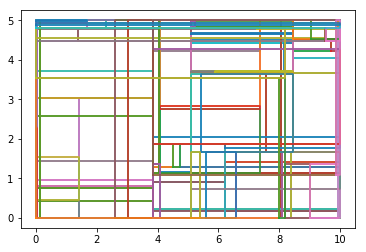

In [110]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#for b in B:
#    plt.plot([b[0,0],b[0,0],b[0,1],b[0,1],b[0,0]],[b[1,0],b[1,1],b[1,1],b[1,0],b[1,0]])

[{'grad': 0.0,
  'int': 6.2750231595224761,
  'patch': [array([ 0.,  0.,  0.]),
   array([  1.37218904,   0.20956335,  17.99855299])]},
 {'grad': 0.0,
  'int': 6.4206294788874985,
  'patch': [array([ 0.        ,  0.20956335,  0.        ]),
   array([  1.37218904,   3.11289095,  17.99855299])]},
 {'grad': 0.0,
  'int': 7.059265236000841,
  'patch': [array([ 1.37218904,  0.        ,  0.        ]),
   array([  3.52662961,   0.20956335,  17.99855299])]},
 {'grad': 0.0,
  'int': 6.4206294788874985,
  'patch': [array([ 1.37218904,  0.20956335,  0.        ]),
   array([  3.52662961,   3.11289095,  17.99855299])]},
 {'grad': 0.0,
  'int': 7.2203600382287663,
  'patch': [array([ 3.52662961,  0.        ,  0.        ]),
   array([  4.46557926,   0.20956335,  17.99855299])]},
 {'grad': 0.0,
  'int': 6.5817242811154237,
  'patch': [array([ 3.52662961,  0.20956335,  0.        ]),
   array([  4.46557926,   1.87357167,  17.99855299])]},
 {'grad': 0.0,
  'int': 7.5276517336293622,
  'patch': [array([ 3